In [2]:
# coding: utf-8

### Possible Message Keys ###

keys = ['X-GM-THRID', 'X-Gmail-Labels', 'Delivered-To', 'Received', 'X-Received', 'Return-Path', 'Received', 
'Received-SPF', 'Authentication-Results', 'DKIM-Signature', 'DomainKey-Signature', 'Received', 'Date', 
'From', 'Reply-To', 'To', 'Message-ID', 'Subject', 'MIME-Version', 'Content-Type', 'x-mid', 'x-job', 
'Feedback-ID', 'x-rpcampaign', 'x-orgId', 'List-Unsubscribe']


### Imports ###

import mailbox
import os
import re

### Functions ###

#Downloads the messages, stops recursing when it reaches html
def showPayload(msg):
    ret = ""
    ignore = ["<html", "<div", "<!DOCT", "<head"]
    stop = False
    
    payload = msg.get_payload()
    global nones
    
    if payload is not None:              
        if msg.is_multipart():
            for subMsg in payload:
                data, stop = showPayload(subMsg)
                
                if not stop:
                    ret += data
                else:
                    break
        else:
            if any(x in payload for x in ignore): #if this is the start of html bullshit, just stop parsing the message
                ret = ""
                stop = True
            return payload, stop
    else:
        nones += 1
        
    return ret, stop


#Dict[candidate_name] -> list of email dicts with keys: Body, From, Subject, Date, Candidates party
def get_cleaned_data():

    directory = os.getcwd() + "/Takeout/Mail"
    files = os.listdir(directory)

    candidate_dict = {}

    for candidate in files:
        mbox = mailbox.mbox(directory + "/" + candidate)

        candidate_name = candidate.split("-")[1][:-5]
        candidate_party = candidate.split("-")[0]
        messages = []

        for message in mbox:
            mini_dict = {}
            body, _ = showPayload(message)

            #This is where we add keys for the messages, so if some data is missing that you want add it here.
            mini_dict["body"] = body
            mini_dict["From"] = message["From"]
            mini_dict["Subject"] = message["Subject"]
            mini_dict["Date"] = message["Date"]
            mini_dict["Party"] = candidate_party

            messages.append(mini_dict)

        candidate_dict[candidate_name] = messages
    return candidate_dict


### Visualization Code

In [27]:
%matplotlib inline
#matplotlib.use('Agg')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


data = get_cleaned_data()

candidates = list(data.keys())
#candidates = ["Trump", "Clinton", "Sanders"]


weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
month_to_num = {"Jan" : 1, "Feb" : 2, "Mar" : 3, "Apr" : 4, "May" : 5, "Jun" : 6, "Jul" : 7, 
               "Aug" : 8, "Sep" : 9, "Oct" : 10, "Nov" : 11, "Dec" : 12}
arr = np.ndarray(shape=(len(candidates),len(weekdays)), dtype=int, order='F')


# Takes a dictionary, and a set of keys that you want the dictionary values in order of
# {"A" : 100, "C" : 50, "B" : 75}, ["A","B","C"] -> [100, 75, 50]
# Assumes values are integers and inserts 
def dict_to_ordered_list(my_dict, order):
    lst = []
    for key in order:
        # Need this If-statement since not all candidates email every day of 
        # the week and defaultdicts are a pain in the ass to initialize
        if key in my_dict:
            lst.append(my_dict[key])
        else:
            lst.append(0)

    return lst

# Gets counts for each day of the week
def weekday_histogram(data, candidate):
    candidate_data = data[candidate]
    weekday_count = defaultdict(int) #defaultdict so all values are initialized for incrementation
        
    for email in candidate_data:
        day = re.match("(\w+),", email["Date"]).group(1) #strip out the weekday from form Day, ...
        weekday_count[day] += 1
        
        
    return dict(weekday_count) #convert to normal dict from defaultdict

#gets the counts for each day of the month cummulatively so the data isn't sparse
def month_histogram(data):
    month_day_data = defaultdict(int) #defaultdict so all values are initialized for incrementation
    
    for candidate in candidates:
        candidate_data = data[candidate]

        for email in candidate_data:
            print(email["Date"])
            day = re.search(r", (\d+) (\w+)", email["Date"])#strip out the weekday from form Day, ...
            print("2016-",month_to_num[day.group(2)], "-", day.group(1), sep="")
            
            month_day_data
            #weekday_count[day] += 1
        
        
    return dict(weekday_count) #convert to normal dict from defaultdict

### Weekday Frequency

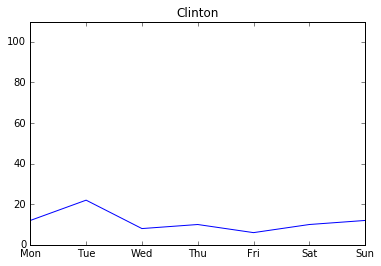

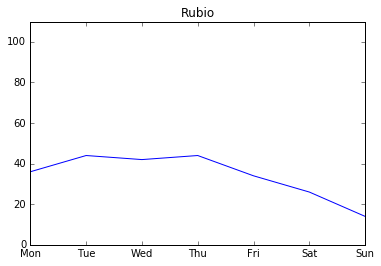

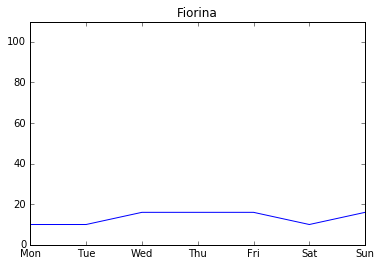

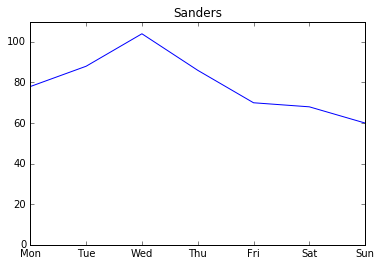

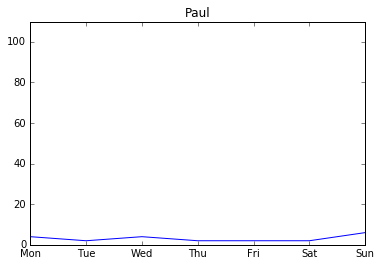

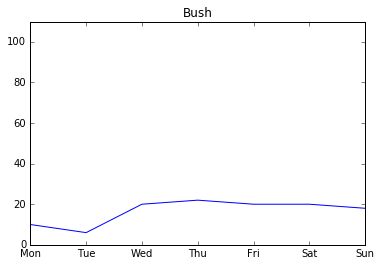

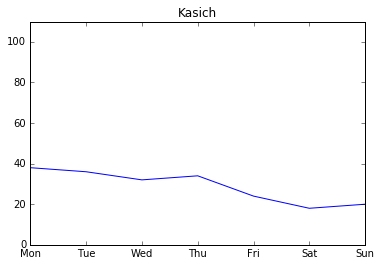

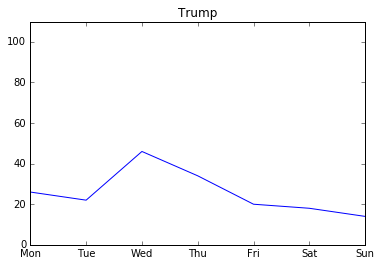

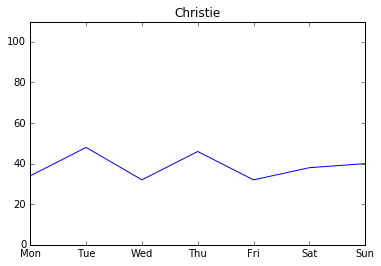

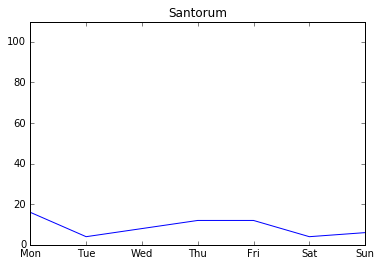

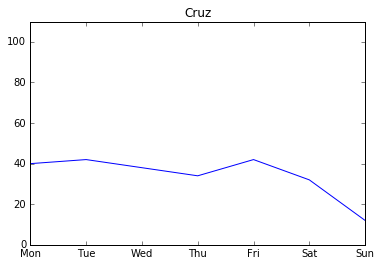

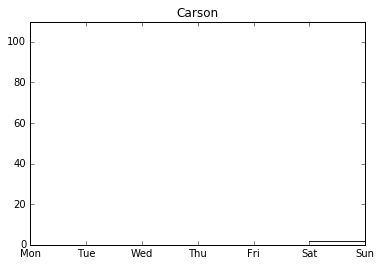

In [28]:
temp_candidate_data = []

for idx, candidate in enumerate(candidates):
    day_of_the_week_data = weekday_histogram(data, candidate)
    temp_candidate_data.append(dict_to_ordered_list(day_of_the_week_data, weekdays))
    plot_me = pd.Series(day_of_the_week_data, index=weekdays)
    plot_me.ix(weekdays)

    # Plot individual graphs
    plot_me.plot(x='Weekday', y='y', title=candidate).set_ylim(0,110)
    #add figure and plot it
    plt.show()

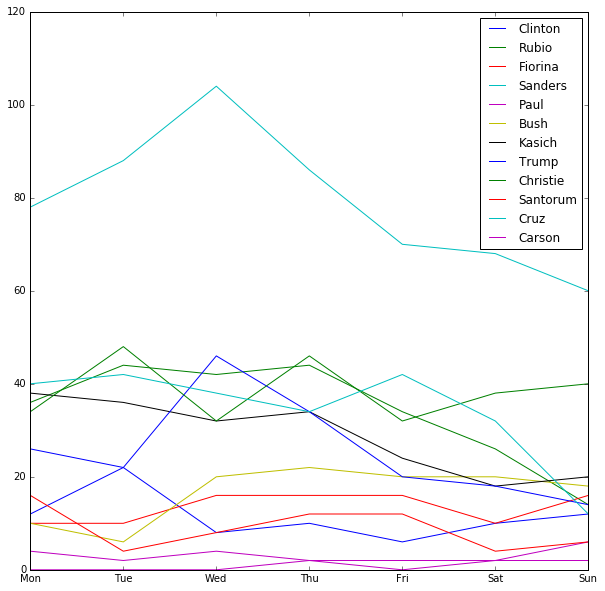

In [46]:
#multicandidate graph
arr = list(zip(*temp_candidate_data)) #need to re-orient the arrays
df = pd.DataFrame(arr, index=weekdays, columns=candidates)
df.plot(figsize=(10,10)); plt.show()

### Monthly Frequency

In [ ]:
month_histogram(data)